# SAR Nonlinear Binomial Models

## Spatially Adjusted Regression - Non-Linear Models (continuous response variable)

Standard Logistic Regression vs Logistic Regression with Eigenvector Spatial Filter

What if the response variables are not binary, but rather take the form of percentages? In such cases, a binomial model may be an option...if you desire the predicted values to lie somewhere between 0.0 and infinity.

In this practice, it is assumed that we are working under a non-linear, non-normal probability model. The goals of this practice are to: 

a) evaluate a standard logistic regression using a continuous dependant variable when spatial autocorrelation may be present and 

b)evaluate the same relationships given the ability to adjust for spatial autocorrelation using the rho term obtained from a logistic model adjusted with an eigenvector spatial filter.

In [1]:
# Load relevant R packages
inLibraries = list('rgdal','spdep','classInt','car','RColorBrewer','MASS')
for (rpack in inLibraries) {
  if (is.element(rpack,installed.packages()[,1])){           
      #Load the library into R
      suppressMessages(library(rpack,character.only = TRUE))
    }
    else {
        print(paste("Warning:  ",rpack," is not an installed package"))
    }
}
#resize plot area
options(repr.plot.width=6, repr.plot.height=6)

## US Farming Data

In this practice, we will be working with county data on agricultural practices in the USA (usagriculture/usfarming.shp). Elements of this dataset were obtained from the 2012 US ag. census: https://www.agcensus.usda.gov/Publications/2012/Online_Resources/Ag_Census_Web_Maps/Data_download/index.php. The fields in this dataset may seem kinda mystical, but they are documented in depth at the website noted above (download the excel and/or pdf file).

There is also a field in the usfarming polygons named 'GRIDCODE', which reflects mean annual precipitation between 1990 and 2009 for each county. The original precipitation data was obtained from: https://catalog.data.gov/dataset/united-states-average-annual-precipitation-1990-2009-direct-download. The precip. data were then spatially joined to the county polygons.

Note: By all means, this is not really a large dataset (3070 records), however, since all operations will be conducted on a remote server, the size of the data coupled with the complexity of the methods could result in longer times required to obtain the results for each step.

First, read in the county level data.

In [2]:
#Read in the featureclass
inFeatures <- readOGR("/dsa/data/geospatial/DS8612/usagriculture","usfarming")

OGR data source with driver: ESRI Shapefile 
Source: "/dsa/data/geospatial/DS8612/usagriculture", layer: "usfarming"
with 3070 features
It has 93 fields


## Subset Features

As agricultural conditions vary considerably over the U.S., let's select a specific state to analyze - California.

Note, that state names are not explicitly included in the dataset. However, the FIPS code for each county is provided. Typically, the first two digits of a Fips code reflect the state id number while the last three reflect a specific county within a state. For more on fips codes see http://www.nws.noaa.gov/mirs/public/prods/maps/cnty_fips_def.htm. In this dataset, the 'atlas_stco' field contains the fips code as a character variable. Thus, in order to select the first two characters associated with a particular state, we need some way to match one portion of a string to another. There are several ways to do this. In this case, first a new field is added to the dataframe 'stcode' and populated with the first two characters in the 'atlas_stco' field which is the fips code. Next, grep() is used to select the fips code prefixes which correspond with the fips code of California ('06').

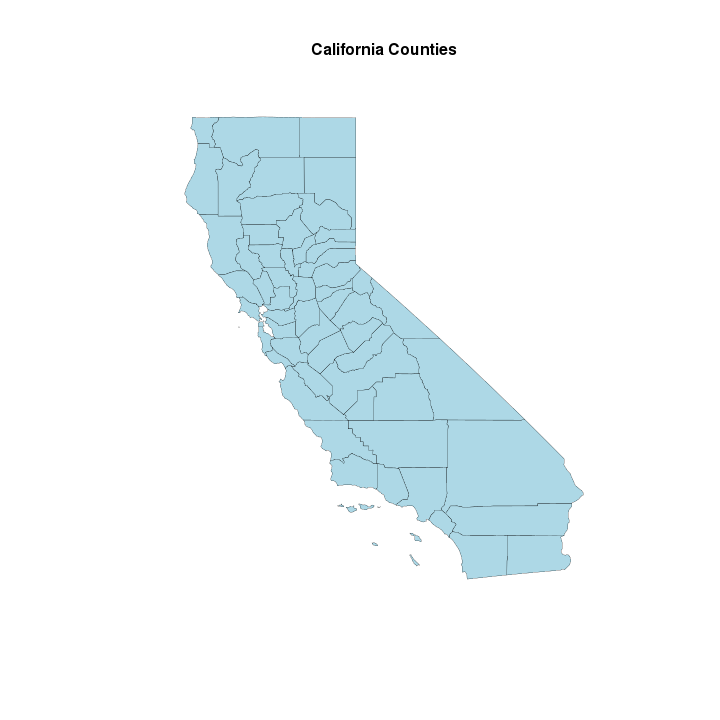

In [3]:
#add new column to dataframe and populate with first two numbers of fips code
inFeatures@data$stcode <- substr(inFeatures@data$atlas_stco, start=1, stop=2)

#select features with a state fips code beginning with...
inFeaturesSubsetA <- inFeatures[grep("06", inFeatures@data$stcode), ]

#plot the state selected
plot(inFeaturesSubsetA,col="lightblue", lwd=.2, main="California Counties",cex.main=.8)

## Generate Neighborhoods for Features¶

As before, generate neighborhoods for each feature. Then test the neighborhoods to see if they are valid. Retain only the features with valid neighborhoods.

In [4]:
#Identify the neighbors of each feature
inFeaturesSubsetA.nb <- poly2nb(inFeaturesSubsetA ,queen=TRUE)

#Select features with at least one neighbor
inFeaturesSubset <- inFeaturesSubsetA[card(inFeaturesSubsetA.nb) >= 1, ]

#Identify the neighbors of each feature having at least one neighbor
inFeaturesSubset.nb <- poly2nb(inFeaturesSubset, queen=TRUE)

#Retrieve neighborhood list
inFeaturesSubset.listb <- nb2listw(inFeaturesSubset.nb,style="B")
inFeaturesSubset.listw <- nb2listw(inFeaturesSubset.nb,style="W")

## Analysis Variables

Configure Variables to Analyze. In this practice, the dependent variable is 'y12_M082_1' (acres of irrigated land as percent of land in farms acreage (year 2012)) and the explanatory varible will be 'GRIDCODE' (mean annual rainfall 1990-2009). Also, 'y12_M249_1' is the number of farms in 2012, a variable that may be of use later on.

Non-linear logistic regression expects the response variable values to range between 0 and 1. As is, the 'y12_M082_1' rates range between 0 and 100%. Thus, before a logistic regression can be applied, they need to be rescaled to the [0,1] range (i.e. divided by 100 in this case).

In [8]:
#acres of irrigated land as a percent of land in farms acreage
inVa <- inFeaturesSubset$y12_M082_1

#number of farms in 2012
inVb <- inFeaturesSubset$y12_M249_1 

#response variables
YVar <- inVa/100

#explanatory variable
Exp1 <- inFeaturesSubset$GRIDCODE

### Plot Observed  Variables

Visualize the dependent variable.

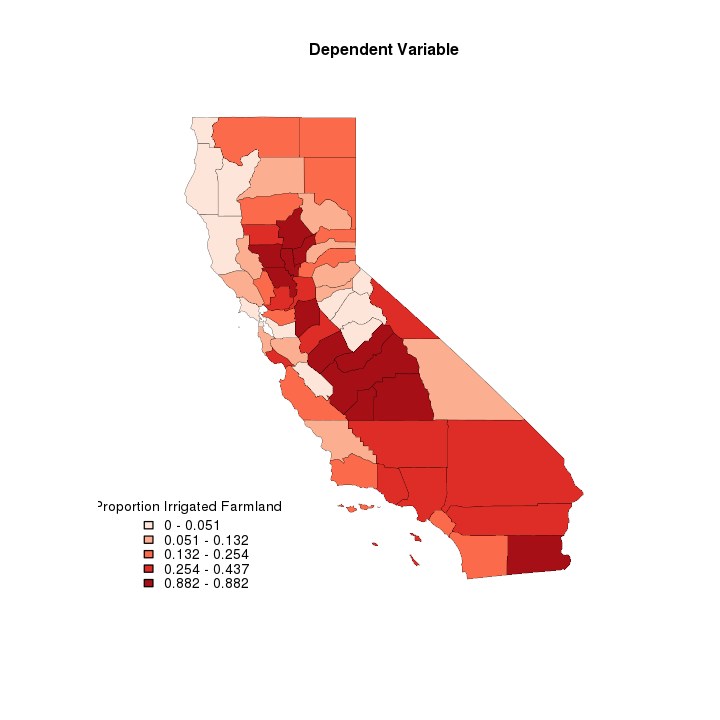

In [9]:
#classify the variable
numcat <- 5
cate <- classIntervals(YVar, numcat, style="quantile")

#assign colors to categories
pal <- brewer.pal(numcat,"Reds")
cols <- findColours(cate,pal)

#plot values
plot(inFeaturesSubset, col=cols, lwd=.2,main="Dependent Variable",cex.main=.8)
brks <- round(cate$brks,3)
leg <- paste(brks[-numcat], brks[-1], sep=" - ")
legend("bottomleft", fill=pal, legend=leg, bty="n",title="Proportion Irrigated Farmland",cex=.7)

### Plot Explanatory Variable

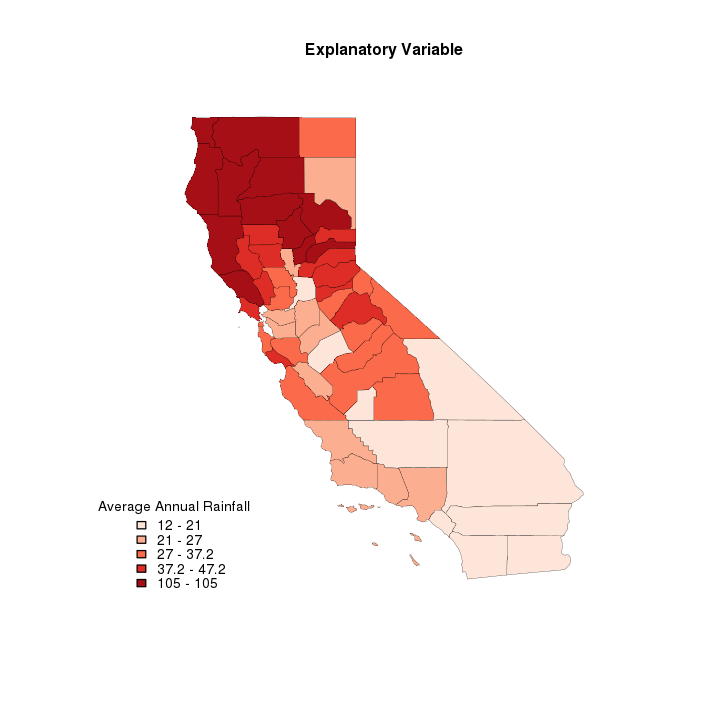

In [10]:
#classify the variable
numcat <- 5
cate <- classIntervals(Exp1, numcat, style="quantile")

#assign colors to categories
pal <- brewer.pal(numcat,"Reds")
cols <- findColours(cate,pal)

#plot values
plot(inFeaturesSubset, col=cols, lwd=.2,main="Explanatory Variable",cex.main=.8)
brks <- round(cate$brks,3)
leg <- paste(brks[-numcat], brks[-1], sep=" - ")
legend("bottomleft", fill=pal, legend=leg, bty="n",title="Average Annual Rainfall",cex=.7)

## Examine Test Statistics for Autocorrelation

Is there any indication of significant spatial autocorrelation within this response variable?

In [11]:
#run autocorrelation tests
moran.test(YVar, inFeaturesSubset.listb)


	Moran I test under randomisation

data:  YVar  
weights: inFeaturesSubset.listb  

Moran I statistic standard deviate = 2.9575, p-value = 0.001551
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
      0.221279446      -0.017543860       0.006520776 


In [12]:
geary.test(YVar, inFeaturesSubset.listb)


	Geary C test under randomisation

data:  YVar 
weights: inFeaturesSubset.listb 

Geary C statistic standard deviate = 2.8001, p-value = 0.002555
alternative hypothesis: Expectation greater than statistic
sample estimates:
Geary C statistic       Expectation          Variance 
      0.724123989       1.000000000       0.009707066 


## Logistic Regression

First, let's estimate a standard logistic regression model. In this case, it will be specified as 'quasibinomial' given the response variable is actually continuous.

In [13]:
YVar.base <- glm(YVar ~ Exp1, family=quasibinomial)
summary(YVar.base)
disp <- summary(YVar.base)$dispersion


Call:
glm(formula = YVar ~ Exp1, family = quasibinomial)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-0.80595  -0.37810  -0.08963   0.21365   1.00056  

Coefficients:
            Estimate Std. Error t value Pr(>|t|)   
(Intercept)  0.02865    0.36238   0.079  0.93726   
Exp1        -0.03523    0.01082  -3.256  0.00192 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for quasibinomial family taken to be 0.2000118)

    Null deviance: 14.418  on 57  degrees of freedom
Residual deviance: 11.828  on 56  degrees of freedom
AIC: NA

Number of Fisher Scoring iterations: 5


### Examine Autocorrelation in Residuals

Is spatial autocorrelation affecting the residuals obtained via the basic logistic model specification?  Well, that seems to be the case...something that really doesn't bode well for interpretation of the results!

In [14]:
#analyze autocorrelation test statistics for residuals
YVar.base.res <- residuals(YVar.base, type="response")

In [15]:
moran.test(YVar.base.res, inFeaturesSubset.listb)


	Moran I test under randomisation

data:  YVar.base.res  
weights: inFeaturesSubset.listb  

Moran I statistic standard deviate = 2.4618, p-value = 0.006912
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
      0.181855792      -0.017543860       0.006560645 


In [16]:
geary.test(YVar.base.res, inFeaturesSubset.listb)


	Geary C test under randomisation

data:  YVar.base.res 
weights: inFeaturesSubset.listb 

Geary C statistic standard deviate = 2.197, p-value = 0.01401
alternative hypothesis: Expectation greater than statistic
sample estimates:
Geary C statistic       Expectation          Variance 
      0.789538481       1.000000000       0.009176764 


## Develop an Eigenvector Spatial Filter

Now, let's try to improve upon this base logistic specification and build an Eigenvector spatial filter.

### Generate Eigenvalues and Eigenvectors

The first step is to compute the MBM matrix. Note that matrix B is the spatial weights matrix.

The second step is to generate eigenvalues and eigenvectors that correspond with the dimensions of the input data.

The third step is to do a first cut to weed out eigenvectors that are likely not that relevant for explaining spatial autocorrelation.

In [17]:
#compute MBM
n <- length(inFeaturesSubset)
M <- diag(n) - matrix(1,n,n)/n
B <- listw2mat(inFeaturesSubset.listb)

MBM <- M %*% B %*% M

#compute eigenvectors and values
eig <- eigen(MBM, symmetric=T)

#Select most relevant eigenvectors (first cut)
cutThreshold <- 0.25
EV <- as.data.frame( eig$vectors[ ,eig$values/eig$values[1] > cutThreshold])
colnames(EV) <- paste("EV", 1:NCOL(EV),sep="")

### Use Stepwise Regression to Refine Set of Eigenvectors

Refine the set of relevant eigenvectors using step-wise regression.  How many Eigenvectors are selected?  According to the code, which parameters influence how many Eigenvectors are selected?  Hey, what is an Eigenvector anyway?

In [18]:
#conduct stepwise regression to spatially filter Eigenvectors
#specify full model with all eigenvectors
YVar.full <- glm(YVar ~ Exp1 + ., data=EV,family=binomial)
#apply stepwise regression
YVar.sf <- stepAIC(glm(YVar~Exp1, data=EV, family=binomial),scale=disp, scope=list(upper=YVar.full), direction="forward",k=1.6)
YVar.sf
coefnm <- names(coef(YVar.sf))

#extract upto exComp components to analyze from final model
exComp <- 7
ctit <- 1
formula2 <- c(YVar ~ Exp1)
formlist <- list()
formula3 <- c()
incnt <- 1
for (ele in coefnm)   {
    if ((ctit <= exComp)&& (startsWith(ele,"EV"))) {
        formula2 <- paste(formula2, "+", sep=" ")
        formula2 <- paste(formula2, ele, sep=" ")
        s1 = unlist(strsplit(ele, split='EV', fixed=TRUE))[2]
        formlist[[ctit]] <- as.numeric(s1)
        
        ctit <- ctit + 1
    }
    incnt <- incnt + 1   
}

formula3 <- unlist(formlist)

Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”

Start:  AIC=49.87
YVar ~ Exp1



Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”Warning message in eval(family$initialize):

       Df Deviance    AIC
+ EV5   1   10.345 44.050
+ EV11  1   10.463 44.640
+ EV1   1   10.935 47.000
+ EV10  1   11.438 49.512
+ EV13  1   11.508 49.864
<none>      11.828 49.866
+ EV6   1   11.550 50.074
+ EV3   1   11.586 50.256
+ EV14  1   11.636 50.507
+ EV7   1   11.677 50.712
+ EV9   1   11.714 50.897
+ EV12  1   11.731 50.980
+ EV4   1   11.810 51.373
+ EV2   1   11.813 51.391
+ EV8   1   11.822 51.432


Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”


Step:  AIC=47.9
YVar ~ Exp1 + EV5



Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”Warning message in eval(family$initialize):

       Df Deviance    AIC
+ EV11  1   9.0067 42.811
+ EV1   1   9.3864 44.709
+ EV3   1   9.9785 47.669
+ EV7   1  10.0068 47.811
<none>     10.3449 47.901
+ EV13  1  10.0593 48.073
+ EV6   1  10.0964 48.259
+ EV10  1  10.1026 48.290
+ EV14  1  10.1620 48.587
+ EV12  1  10.2647 49.100
+ EV9   1  10.2922 49.238
+ EV2   1  10.3405 49.479
+ EV4   1  10.3447 49.500
+ EV8   1  10.3448 49.501


Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”


Step:  AIC=45.96
YVar ~ Exp1 + EV5 + EV11



Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”Warning message in eval(family$initialize):

       Df Deviance    AIC
+ EV1   1   8.4338 44.696
+ EV3   1   8.5655 45.355
+ EV7   1   8.5944 45.500
+ EV13  1   8.6403 45.729
<none>      9.0067 45.961
+ EV12  1   8.7525 46.290
+ EV10  1   8.7726 46.390
+ EV14  1   8.8583 46.819
+ EV6   1   8.8895 46.975
+ EV9   1   8.9682 47.368
+ EV2   1   8.9823 47.439
+ EV4   1   9.0014 47.534
+ EV8   1   9.0067 47.561


Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”


Step:  AIC=46.91
YVar ~ Exp1 + EV5 + EV11 + EV1




Call:  glm(formula = YVar ~ Exp1 + EV5 + EV11 + EV1, family = binomial, 
    data = EV)

Coefficients:
(Intercept)         Exp1          EV5         EV11          EV1  
    0.24132     -0.04444     -3.13408      2.56349     -2.16566  

Degrees of Freedom: 57 Total (i.e. Null);  53 Residual
Null Deviance:	    14.42 
Residual Deviance: 8.434 	AIC: 48.91

### Given the selected Eigenvectors, run the spatially filtered model

How should the results be interpreted?  How do the results differ from the basic logistic regresssion? Note that deviance of spatially filtered regression is much lower than that of the basic logistic regression. What is deviance and dispersion and how should those be interpreted?

In [20]:
#populate model with selected Eigenvectors
YVar.sf <- glm(formula2, data=EV, family=quasibinomial)
summary(YVar.sf)

paste("Deviance Base Model = ",summary(YVar.base)$deviance/YVar.base$df.residual)
paste("Deviance Spatial Filter = ",summary(YVar.sf)$deviance/YVar.sf$df.residual)
paste("Dispersion = ",summary(YVar.sf)$dispersion)


Call:
glm(formula = formula2, family = quasibinomial, data = EV)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-0.84039  -0.28995  -0.05292   0.26196   1.07524  

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.24132    0.42118   0.573 0.569089    
Exp1        -0.04444    0.01272  -3.495 0.000967 ***
EV5         -3.13408    0.97717  -3.207 0.002274 ** 
EV11         2.56349    1.00117   2.561 0.013337 *  
EV1         -2.16566    1.09867  -1.971 0.053937 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for quasibinomial family taken to be 0.143709)

    Null deviance: 14.4176  on 57  degrees of freedom
Residual deviance:  8.4338  on 53  degrees of freedom
AIC: NA

Number of Fisher Scoring iterations: 5


[1] "Deviance Base Model =  0.211217979221281"

[1] "Deviance Spatial Filter =  0.159128081810892"

[1] "Dispersion =  0.143709005239712"

### Examine Test Statistics for Autocorrelation in Spatial Filter Model

Is spatial autocorrelation at work within the spatial filter?

In [21]:
#analyze autocorrelation test statistics for residuals
sfilter <- as.matrix(EV[ ,formula3]) %*% as.matrix(YVar.sf$coefficients[c(-1,-2)])
sfvector <- as.vector(sfilter)
moran.test(sfvector, inFeaturesSubset.listb)
geary.test(sfvector, inFeaturesSubset.listb)


	Moran I test under randomisation

data:  sfvector  
weights: inFeaturesSubset.listb  

Moran I statistic standard deviate = 9.2638, p-value < 2.2e-16
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
      0.730861946      -0.017543860       0.006526792 



	Geary C test under randomisation

data:  sfvector 
weights: inFeaturesSubset.listb 

Geary C statistic standard deviate = 6.3117, p-value = 1.38e-10
alternative hypothesis: Expectation greater than statistic
sample estimates:
Geary C statistic       Expectation          Variance 
      0.380713333       1.000000000       0.009627048 


## #Examine Autocorrelation in Spatially Filtered Residuals

Is spatial autocorrelation affecting the residuals obtained given the spatial filter was applied?

In [22]:
#analyze autocorrelation test statistics for residuals
YVar.sf.res <- residuals(YVar.sf, type="response")
moran.test(YVar.sf.res, inFeaturesSubset.listb)
geary.test(YVar.sf.res, inFeaturesSubset.listb)


	Moran I test under randomisation

data:  YVar.sf.res  
weights: inFeaturesSubset.listb  

Moran I statistic standard deviate = -0.42614, p-value = 0.665
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
     -0.051684056      -0.017543860       0.006418369 



	Geary C test under randomisation

data:  YVar.sf.res 
weights: inFeaturesSubset.listb 

Geary C statistic standard deviate = 0.40645, p-value = 0.3422
alternative hypothesis: Expectation greater than statistic
sample estimates:
Geary C statistic       Expectation          Variance 
       0.95723746        1.00000000        0.01106917 


### Visualize the Fitted Values

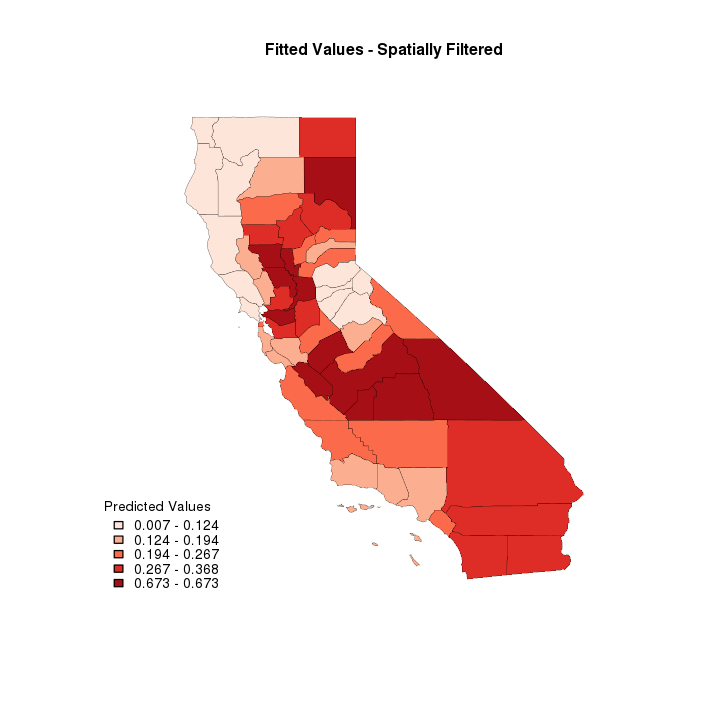

In [23]:
#classify the variable
numcat <- 5
cate <- classIntervals(YVar.sf$fitted, numcat, style="quantile")

#assign colors to categories
pal <- brewer.pal(numcat,"Reds")
cols <- findColours(cate,pal)

#plot values
plot(inFeaturesSubset, col=cols, lwd=.2,main="Fitted Values - Spatially Filtered",cex.main=.8)
brks <- round(cate$brks,3)
leg <- paste(brks[-numcat], brks[-1], sep=" - ")
legend("bottomleft", fill=pal, legend=leg, bty="n",title="Predicted Values",cex=.7)

### Visualize the Spatial Filter

Display the spatial filter to get a sense of how spatial autocorrelation was ultimately modeled in this application.

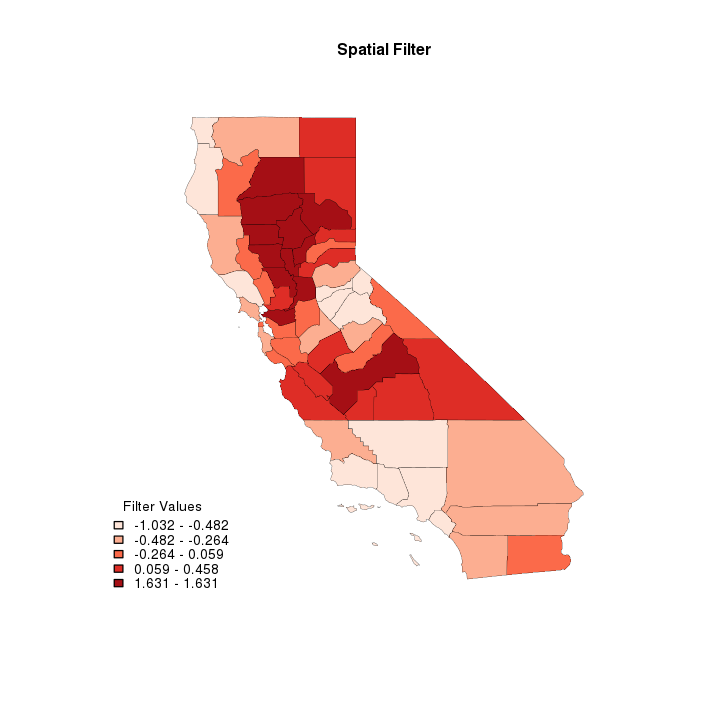

In [24]:
#classify the variable
numcat <- 5
cate <- classIntervals(sfvector, numcat, style="quantile")

#assign colors to categories
pal <- brewer.pal(numcat,"Reds")
cols <- findColours(cate,pal)

#plot values
plot(inFeaturesSubset, col=cols, lwd=.2,main="Spatial Filter",cex.main=.8)
brks <- round(cate$brks,3)
leg <- paste(brks[-numcat], brks[-1], sep=" - ")
legend("bottomleft", fill=pal, legend=leg, bty="n",title="Filter Values",cex=.7)